In [ ]:
# import and log in to stuff
from scipy.interpolate import CubicSpline, interp1d
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import yfinance
from yahoo_fin import options
import requests
import json
from KalshiClientsBase import ExchangeClient
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
import time
import datetime

In [ ]:
# log in to kalshi

url = "https://trading-api.kalshi.com/v1"

with open("config.json") as json_data_file:
    info = json.load(json_data_file)

response = requests.post(url + "/log_in", json=info).json()
headers = {
    "Content-Type": "application/json",
    "Authorization": response["user_id"] + " " + response["token"] 
}

In [ ]:
spy = pd.read_csv('spy_all')

In [ ]:

# use options to get implied df of spy
def prob(a, b, quote_date, expiry_date, spy):
    if type(a)== str:
        a = a.replace(',', '')
        a = float(a)
        a = round(a)
        a = int(a)
    if type(b)== str:
        b = b.replace(',', '')
        b = float(b)
        b = round(b)
        b = int(b)
    
    spy.sort_values(by=[' [STRIKE]'])
    spy = spy[spy[" [QUOTE_DATE]"] == " " + quote_date]
    spy = spy[spy[" [EXPIRE_DATE]"] == " " + expiry_date]

    if len(spy[" [C_BID]"]) < 5 or len(spy[" [C_ASK]"]) < 5 or len(spy[" [STRIKE]"]) < 5:
        return -1
    x = spy[" [STRIKE]"]
    y = (spy[" [C_BID]"] + spy[" [C_ASK]"])/2
    if len(x) < 2 or len(y) < 2:
        return -1
    
    cs = CubicSpline(x, y)
    xs = np.arange(x.min(), x.max(), .001)
    # plt.scatter(x, y, marker=".")
    # plt.plot(xs, cs(xs))

    y2 = cs(xs, 2)
    y2 = [0 if y < 0 else y for y in y2]
    sum = []
    s = 0
    for y in y2:
        s += y
        sum.append(s)
    sum = [s/sum[-1] for s in sum]

    a_ind = int((a - int(xs.min())) * 1000)
    if a_ind < 0:
        a_ind = 0
    b_ind = int((b - int(xs.min())) * 1000)
    if b_ind < 0:
        b_ind = 0
    a_ind = min(len(sum) - 1, a_ind)
    b_ind = min(len(sum) - 1, b_ind)
    return sum[b_ind] - sum[a_ind]

In [ ]:
# trade on kalshi
from datetime import date
profit_sum = 0
profit = []
markets = requests.get(url + "/cached/markets", params = {}, headers=headers).json()
market_ids = []
expirys = []
opens = []
rulebooks = []
results = []
for market in markets['markets']:
    if 'INXW' in market['ticker_name'] and market['status'] == "finalized":
        market_ids.append(market['id'])
        expirys.append(market['close_date'])
        opens.append(market['open_date'])
        rulebooks.append(market['rulebook_variables'])
        results.append(market['last_price'])
for i in range(len(market_ids)):
    print(profit_sum)
    market = market_ids[i]
    expiry = expirys[i]
    open = opens[i]
    rulebook = rulebooks[i]
    result = results[i]
    a = 0
    b = 10000
    if (rulebook["Above/Below/Between"] == "between"):
        a = rulebook["Floor_strike"]
        b = rulebook["Cap_strike"]
    if (rulebook["Above/Below/Between"] == "below"):
        b = rulebook["Value"]
    if (rulebook["Above/Below/Between"] == "above"):
        a = rulebook["Value"]


    expiry_tuple = datetime.datetime(int(expiry[0:4]), int(expiry[5:7]), int(expiry[8:10]), int(expiry[11:13]))
    expiry_ts =time.mktime(expiry_tuple.timetuple())
    open_tuple = datetime.datetime(int(open[0:4]), int(open[5:7]), int(open[8:10]), 16)
    open_ts = time.mktime(open_tuple.timetuple())
    response = requests.get(url + "/cached/markets/" + market + "/stats_history", params = {}, headers=headers).json()
    for j in range(len(response['market_stats_points'])):
        stat = response['market_stats_points'][j]
        if stat["ts"] > open_ts:
            price = .5 * (stat['yes_bid'] + stat['yes_ask'])
            open_date = str(datetime.datetime.fromtimestamp(open_ts))[0:10]
            try:
                p = prob(a, b, open_date, expiry[0:10], spy)
            except:
                print("Exception with " + str(a) + " " + str(b) + " " + str(open_date) + " " + str(expiry))
                p = -1
            if p == -1:
                profit.append(0)
                break
            if (p > price):
                #buy
                profit.append(result - price)
                profit_sum += result - price

            elif (p < price):
                #sell
                profit.append(price - result)
                profit_sum += price - result

            else:
                profit.append(0)
            open_ts += 86400


In [ ]:
profit_over_time = []
for i in range(len(profit)):
    if i == 0:
        profit_over_time.append(profit[i])
    else:    
        profit_over_time.append(profit_over_time[-1] + profit[i])

month_x = np.arange(0., 6., 6/len(profit_over_time))
plt.plot(month_x, profit_over_time)

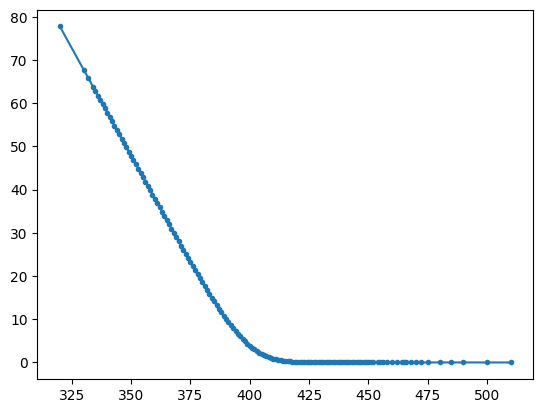

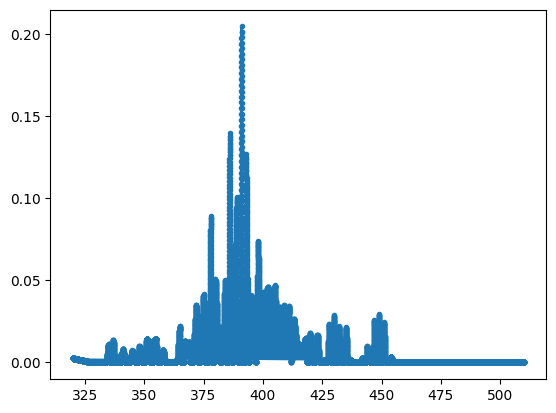

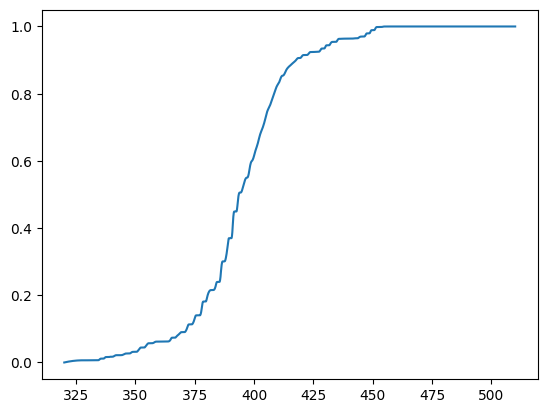

In [6]:
# spy = pd.read_csv('spy_all')
spy.sort_values(by=[' [STRIKE]'])
spy = spy[spy[" [QUOTE_DATE]"] == " 2022-09-07"]
spy = spy[spy[" [EXPIRE_DATE]"] == " 2022-09-14"]

x = spy[" [STRIKE]"]
y = (spy[" [C_BID]"] + spy[" [C_ASK]"])/2

cs = CubicSpline(x, y)
xs = np.arange(x.min(), x.max(), .01)
plt.scatter(x, y, marker=".")
plt.plot(xs, cs(xs))

y2 = cs(xs, 2)
y2 = [0 if y < 0 else y for y in y2]
sum = []
s = 0
for y in y2:
    s += y
    sum.append(s)
sum = [s/sum[-1] for s in sum]

plt.figure(2)
plt.fill(xs, y2)
plt.plot(xs, y2, marker='.')
plt.figure(3)
plt.plot(xs, sum)


In [ ]:
# # butterfly

# spy = pd.read_csv('spy_eod_202201.txt')
# spy.filter(items=[' [STRIKE]', ' [C_BID]', ' [C_ASK]'])
# spy.sort_values(by=[' [STRIKE]'])


# spy["Midpoint"] = (spy[" [C_BID]"] + spy[" [C_ASK]"])/2

# spy["[STRIKE]1"] = spy.shift(-1)[" [STRIKE]"]
# spy["[STRIKE]2"] = spy.shift(-2)[" [STRIKE]"]
# spy["b"] = (spy["[STRIKE]2"] - spy[" [STRIKE]"])/(spy["[STRIKE]2"] - spy["[STRIKE]1"])
# spy["c"] = (spy["[STRIKE]1"] - spy[" [STRIKE]"])/(spy["[STRIKE]2"] - spy["[STRIKE]1"])

# spy["Cost"] = spy["Midpoint"] - (spy["b"]) * spy.shift(-1)["Midpoint"] + (spy["c"]) * spy.shift(-2)["Midpoint"]

# spy["Payoff"] = (spy["[STRIKE]1"] - spy[" [STRIKE]"]) * (spy["[STRIKE]1"] - spy[" [STRIKE]"]) / 2 + (spy["[STRIKE]1"] - spy[" [STRIKE]"]) * (spy["[STRIKE]2"] - spy["[STRIKE]1"]) / 2
# spy["Prob"] = spy["Cost"]/spy["Payoff"]
# spy2 = spy.drop(spy[spy["Prob"] < 0].index)

# plt.scatter(spy2["[STRIKE]1"], spy2["Prob"])

In [ ]:
# # use yfinance to figure out implied pdf of options
# spy = options.get_calls("SPY", date="11/04/22")
# x = spy.Strike
# y = .5 * (spy.Bid + spy.[C_ASK])
# cs = CubicSpline(x, y)
# xs = np.arange(x.min(), x.max())
# plt.scatter(x, y, marker=".")
# plt.plot(xs, cs(xs))


# # use difference to execute trades
# plt.plot(xs, cs(xs, 2) * pow(2.71828, .04), label="S''")